# `photoeccentric` Tutorial: Uniform priors (Comparison)

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
nwalk = 64
nsteps = 1000
ndiscard = 500
arrlen = (nsteps-ndiscard)*nwalk

In [193]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

In [194]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

In [195]:
# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
# TODO: Vet based on KOI not KIC
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]

# spectplanets.to_csv('spectplanets.csv')

In [196]:
# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.rename(columns={"source_id": "m_source_id"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.merge(muirhead_data, muirhead_gaia, how='inner', left_on='KIC', right_on='kepid')
#muirhead_comb.to_csv('muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb[muirhead_comb.lum_val.notnull()]
#muirhead_comb_lums.to_csv('muirhead_comb_lums.csv')

/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


# Defining a "test planet"

In [197]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]


In [198]:
# Read in MESA isochrones
# isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')


In [199]:
# iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb_lums, isochrones, gaia_lum=False, source='Muirhead')

In [200]:
# Write to csv, then read back in (prevents python notebook from lagging)
# iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

### Reading in isochrones for this KIC

In [201]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [202]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

### Calculating density distribution

In [203]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

In [204]:
#plt.hist(rho_star, bins=20)
#plt.xlabel('Stellar Density Histogram (kg m^-3)', fontsize=20)

# Creating a fake light curve based on a real planet

In [205]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


# Uniform Prior
# $e=0.9$, $w=-90.0$

In [245]:
time = np.arange(-25, 25, cadence)

In [246]:
# Calculate flux from transit model
e = 0.9
w = -90.0
flux = ph.integratedlc(time, period, rprs, a_rs, 0.9, i, -90.0)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

In [247]:
# plt.errorbar(time, nflux, yerr=flux_err)
# plt.xlabel('Time')
# plt.ylabel('Flux')
# plt.xlim(-1, 1)

## Fitting the transit

In [248]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [249]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF

Period fit:  4.828282828282829


In [250]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time1, nflux1, fluxerr1 = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

In [251]:
mid = ph.get_mid(time1)
ptime1 = ph.get_ptime(time1, mid, 29)

In [252]:
# Inital guess: period, rprs, a/Rs, i, t0
p0 = [per_guess, rprs, 20, 89, 0.0]

dr = 'e_' + str(e) + '_w_' + str(w)
direct = 'plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, pdist, rdist, adist, idist, t0dist = ph.mcmc_fitter(p0, time1, ptime1, nflux1, fluxerr1, nwalk, nsteps, ndiscard, e, w, direct)



100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


In [253]:
per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)
t0_f = ph.mode(t0dist)

In [254]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f, t0_f)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98
t0: 0


Fit params:
Rp/Rs:  0.03618269993327457
a/Rs:  7.6650005642372925
i (deg):  87.37744618357901
t0:  0.0003497138099671365


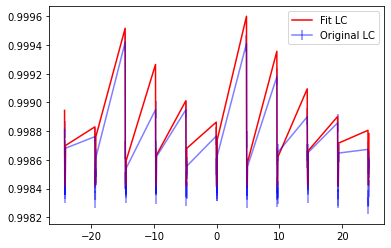

In [255]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)


print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('t0: 0')

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('t0: ', t0_f)

In [256]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:61: RuntimeWarning: invalid value encountered in arcsin
  T14[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1+rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:113: RuntimeWarning: invalid value encountered in arcsin
  T23[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1-rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook


In [257]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

Print $g$ and $\sigma_{g}$:

In [258]:
g_mean

0.2092745512587343

In [259]:
g_sigma

0.030927726347780612

In [260]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [261]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:04<00:00, 1184.37it/s]


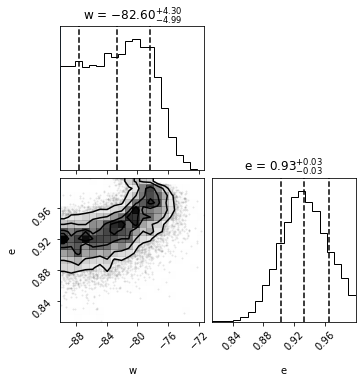

In [262]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[-90.0, 0.3], quantiles=[0.16, 0.5, 0.84], plot_contours=True)

# Uniform Prior
# $e=0.0$, $w=90.0$

In [224]:
time = np.arange(-25, 25, cadence)

In [225]:
# Calculate flux from transit model
e = 0.0
w = 90.0
flux = ph.integratedlc(time, period, rprs, a_rs, 0.0, i, -90.0)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

In [226]:
# plt.errorbar(time, nflux, yerr=flux_err)
# plt.xlabel('Time')
# plt.ylabel('Flux')
# plt.xlim(-1, 1)

## Fitting the transit

In [227]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [228]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF

Period fit:  4.828282828282829


In [229]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time1, nflux1, fluxerr1 = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

In [230]:
mid = ph.get_mid(time1)
ptime1 = ph.get_ptime(time1, mid, 29)

In [231]:
# Inital guess: period, rprs, a/Rs, i, t0
p0 = [per_guess, rprs, 20, 89, 0.0]

dr = 'e_' + str(e) + '_w_' + str(w)
direct = 'plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, pdist, rdist, adist, idist, t0dist = ph.mcmc_fitter(p0, time1, ptime1, nflux1, fluxerr1, nwalk, nsteps, ndiscard, e, w, direct)



100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


In [232]:
per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)
t0_f = ph.mode(t0dist)

In [233]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f, t0_f)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98
t0: 0


Fit params:
Rp/Rs:  0.03629590919017171
a/Rs:  32.85136906624141
i (deg):  89.4508697894753
t0:  0.00010738072636328855


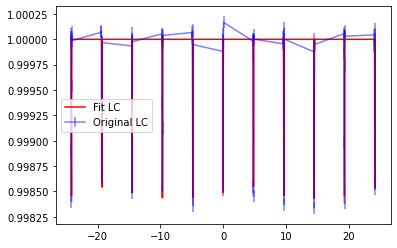

In [234]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)


print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('t0: 0')

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('t0: ', t0_f)

In [235]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

In [236]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

Print $g$ and $\sigma_{g}$:

In [237]:
g_mean

0.918070680020556

In [238]:
g_sigma

0.1929093861596229

In [239]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [240]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:03<00:00, 1283.54it/s]


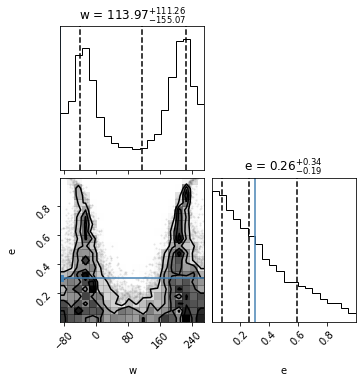

In [241]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[-90.0, 0.3], quantiles=[0.16, 0.5, 0.84], plot_contours=True)